# Validation of AgStack Level 1 Model

In [1]:
import datetime
import glob
import os
import numpy as np
import h5py
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from agstack.models import TCF
from agstack.drivers import drivers_for_tcf
from agstack.io import drivers_from_csv, params_dict_from_json

FLUXNET_HDF5 = '/anx_lagr3/arthur.endsley/SMAP_L4C/calibration/v8_Y2023/L4_C_v8_new_AmeriFlux-FLUXNET-ICOS_towers.h5'
SITE_IDS = {
    'US-Bi1': 8,
    'US-Bi2': 7,
    'US-CF1': 8, # Crop not specified but it looks like broadleaf
    'US-CF2': 8, # Crop not specified, choosing higher LUE_max
    'US-CF3': 8, # Crop not specified, choosing higher LUE_max
    'US-CF4': 8, # Crop not specified, choosing higher LUE_max
}
FILE_TPL = '/home/arthur.endsley/Workspace/NTSG/projects/Y2023_Field-Scale_C_Flux/data/tower_data/{site_id}_*.csv'

## Executive Summary

- In a managed alfalfa field, both modeled and observed GPP, NEE show expected changes in response to repeated mowing.
- GPP RMSE ranges from 3.0 to 4.9 [g C m-2 day-1], but these sites have high productivity. Normalized RMSE is 12-22%.
- NEE RMSE ranges from 3.8 to 4.2 [g C m-2 day-1], which is pretty high, unfortunately. This is partly due to low modeled GPP magnitudes.
- GPP and NEE time series correlations are relatively strong, with Pearson's $r\in [0.43, 0.87]$.

**GPP**

- The model generally underestimates GPP, particularly at the alfalfa site where GPP shows high variability during the growing season.
- Daily GPP at these sites is most strongly controlled by fPAR and vapor pressure deficit (VPD). VPD determines much of the diurnal variation in GPP.
- Low fPAR variability is the chief reason for the model's poor prediction of GPP variability. While fPAR does predict the timing of swings in observed GPP, the changes in fPAR magnitude are too small.

## Introduction

[**US-Bi1 is an alfalfa crop**](https://fluxnet.org/sites/siteinfo/US-Bi1) surrounded by wetlands, with an SOC content of 4500 [g C m-2], based on SoilGrids. Alfalfa is considered a broadleaf crop (PFT 8).

[**US-Bi2 is a nearby corn crop**](https://fluxnet.org/sites/siteinfo/US-Bi2), with an SOC content of 4635 [g C m-2], based on SoilGrids. Corn is considered a cereal crop (PFT 7).

> "corn is growing on an island in the Sacramento San Joaquin Delta. This site has deep peat that was drained for farming. Over the past 100 years there has been excessive subsidence of the peat in the delta"

- [Based on field notes,](https://nature.berkeley.edu/biometlab/bmetdata/fieldnotes.php?screen=list&LS=Bouldin+Corn&LA=0&LY=2020&LM=0&ST=&SD=&fnlimit=Submit) field was harvested sometime between October 5 and October 22, 2023.
- Corn had tassels and cobbs by July 21, 2023.
- On July 30, "the bottom few leaves of the corn plants were senescent."
- Field was likely irrigated between July 30 and August 5, which might explain the GPP pulse around July 31.
- On August 11 "the corn near the tower were all yellow, but the regular corn farther out in the field were light-green at the top."

**We don't have field notes on the other 4 tower sites.**

## Data Preparation

In [2]:
datasets = []

for site_id in SITE_IDS.keys():
    filename = glob.glob(FILE_TPL.format(site_id = site_id)).pop()
    # dates_list is taken to be the last dates list loaded (all the same)
    data, dates_list = drivers_from_csv(filename)
    # Get the dataset and the PFT to use when modeling
    datasets.append((site_id, data, SITE_IDS[site_id]))
    print(f'{site_id}: {dates_list[0]} - {dates_list[-1]}')

US-Bi1: 2020-04-01 00:00:00 - 2021-12-31 00:00:00
US-Bi2: 2020-04-01 00:00:00 - 2021-12-31 00:00:00
US-CF1: 2020-04-01 00:00:00 - 2021-12-31 00:00:00
US-CF2: 2020-04-01 00:00:00 - 2021-12-31 00:00:00
US-CF3: 2020-04-01 00:00:00 - 2021-12-31 00:00:00
US-CF4: 2020-04-01 00:00:00 - 2021-12-31 00:00:00


### Loading Independent Modeled GPP

A stoichiometry model was also used to relate field-measured ET to GPP.

In [3]:
alt_gpp = []

for site_id in SITE_IDS.keys():
    filename = glob.glob(FILE_TPL.format(site_id = site_id)).pop()
    df = pd.read_csv(filename)
    alt_gpp.append(df['gpp'].values)
    
len(alt_gpp)

6

## Model Spin-Up and Forward Run

In [4]:
all_models = []
for site_id, data, pft in datasets:
    # Load driver (meteorology)
    drivers = drivers_for_tcf(data)

    # Wild guess as to the initial soil carbon state
    state = np.array([[300, 300, 4000]]).T

    # Read in model parameters
    params = params_dict_from_json('/usr/local/dev/agstack/agstack/data/SPL4CMDL_V7_BPLUT.json')

    model = TCF(params, [pft], state)
    tol = model.spin_up(dates_list, drivers)
    all_models.append(model)

  4%|█▊                                                   | 35/1000 [00:02<00:57, 16.85it/s]


In [5]:
for i, site_id in enumerate(SITE_IDS.keys()):
    print(f'Steady-state SOC, {site_id}:', all_models[i].state.soc.sum())

Steady-state SOC, US-Bi1: 4804.5728
Steady-state SOC, US-Bi2: 2326.135
Steady-state SOC, US-CF1: 2134.3945
Steady-state SOC, US-CF2: 2077.2966
Steady-state SOC, US-CF3: 2225.7007
Steady-state SOC, US-CF4: 2031.1338


In [6]:
results = np.nan * np.ones((len(all_models), 2, len(dates_list)))

for m, model in enumerate(all_models):
    # Load driver (meteorology)
    drivers = drivers_for_tcf(datasets[m][1])
    nee, gpp, _ = model.forward_run(drivers)
    results[m][0] = nee
    results[m][1] = gpp

100%|██████████████████████████████████████████████████| 640/640 [00:00<00:00, 11215.98it/s]


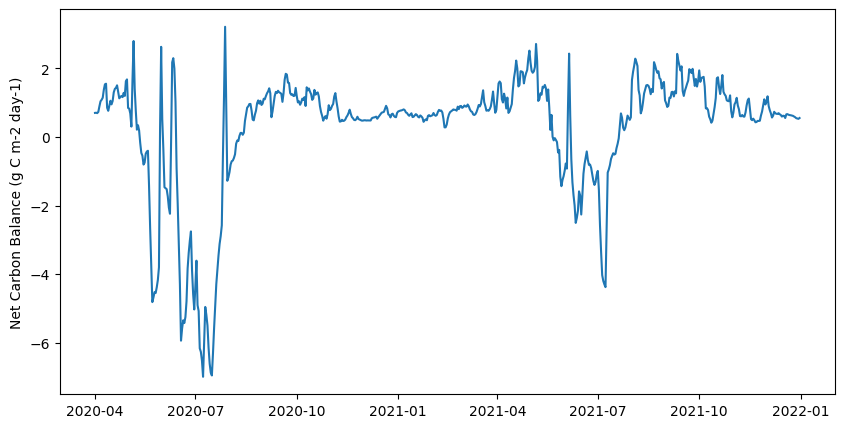

In [7]:
# As an example, show the very last site modeled (leftover "nee" local variable)
pyplot.figure(figsize = (10, 5))
pyplot.plot(dates_list, nee[0])
pyplot.ylabel('Net Carbon Balance (g C m-2 day-1)')
pyplot.show()

---

## Validation Against Tower Fluxes

In [8]:
site_list = [s.encode('utf-8') for s in SITE_IDS.keys()]

with h5py.File(FLUXNET_HDF5, 'r') as hdf:
    idx = np.argwhere(np.in1d(hdf['site_id'][:], site_list)).ravel()
    nee_obs = hdf['NEE'][:,idx]
    gpp_obs = hdf['GPP'][:,idx]
    time = hdf['time'][:]

In [9]:
nee = results[:,0]
gpp = results[:,1]

t0 = np.argwhere(np.logical_and(time[:,0] == 2020, time[:,1] == 4)).min()
t1 = np.argwhere(np.logical_and(time[:,0] == 2021, time[:,1] == 12)).max() + 1
time[t0:t1]

array([[2020,    4,    1],
       [2020,    4,    2],
       [2020,    4,    3],
       ...,
       [2021,   12,   29],
       [2021,   12,   30],
       [2021,   12,   31]], dtype=int16)

### Gross Primary Productivity (GPP)

#### RMSE and Normalized RMSE

In [10]:
for i in range(0, len(all_models)):
    mask = np.isnan(gpp_obs[t0:t1,i]) # Mask out NaNs in the observed data
    rmse = mean_squared_error(gpp_obs[t0:t1,i][~mask], gpp[i][~mask], squared = False)
    print(f'{datasets[i][0]}: %.2f [g C m-2 day-1]' % rmse)

US-Bi1: 3.94 [g C m-2 day-1]
US-Bi2: 5.64 [g C m-2 day-1]
US-CF1: 2.36 [g C m-2 day-1]
US-CF2: 2.21 [g C m-2 day-1]
US-CF3: 1.61 [g C m-2 day-1]
US-CF4: 3.29 [g C m-2 day-1]


In [11]:
for i in range(0, len(all_models)):
    mask = np.isnan(gpp_obs[t0:t1,i]) # Mask out NaNs in the observed data
    rmse = mean_squared_error(gpp_obs[t0:t1,i][~mask], gpp[i][~mask], squared = False)
    nrmse = rmse / (np.nanmax(gpp_obs[t0:t1,i]) - np.nanmin(gpp_obs[t0:t1,i]))
    print(f'{datasets[i][0]}: %.1f%%' % (100 * nrmse))

US-Bi1: 18.3%
US-Bi2: 22.5%
US-CF1: 12.3%
US-CF2: 13.0%
US-CF3: 8.8%
US-CF4: 14.2%


#### Pearson's Correlation

In [12]:
for i in range(0, len(all_models)):
    mask = np.isnan(gpp_obs[t0:t1,i]) # Mask out NaNs in the observed data
    corr = np.corrcoef(gpp_obs[t0:t1,i][~mask], gpp[i][~mask])[0,1]
    print(f'{datasets[i][0]}: %.2f' % corr)

US-Bi1: 0.75
US-Bi2: 0.80
US-CF1: 0.89
US-CF2: 0.93
US-CF3: 0.88
US-CF4: 0.86


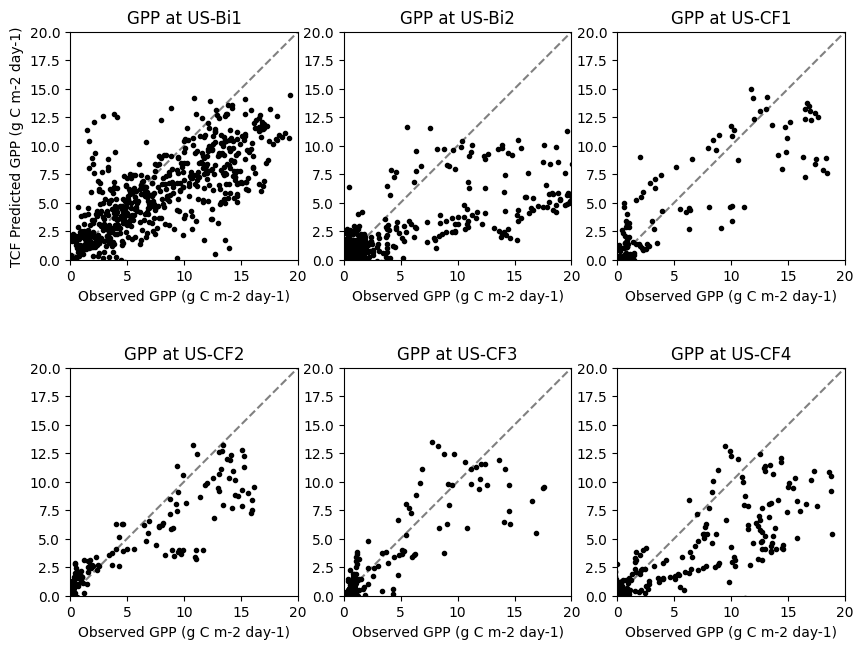

In [13]:
fig, _axs = pyplot.subplots(2, 3, figsize = (10, 8))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot([0, 1], [0, 1], transform = axs[i].transAxes, linestyle = 'dashed', color = 'gray')
    axs[i].plot(gpp_obs[t0:t1,i], gpp[i], 'k.')
    axs[i].set_title(f'GPP at {datasets[i][0]}')
    axs[i].set_aspect(1)
    axs[i].set_xlim(0, 20)
    axs[i].set_ylim(0, 20)
    axs[i].set_xlabel('Observed GPP (g C m-2 day-1)')

axs[0].set_ylabel('TCF Predicted GPP (g C m-2 day-1)')
pyplot.show()

### Net Ecosystem Exchange (NEE)

#### RMSE

In [14]:
for i in range(0, len(all_models)):
    mask = np.isnan(nee_obs[t0:t1,i]) # Mask out NaNs in the observed data
    rmse = mean_squared_error(nee_obs[t0:t1,i][~mask], nee[i][~mask], squared = False)
    print(f'{datasets[i][0]}: %.2f [g C m-2 day-1]' % rmse)

US-Bi1: 3.64 [g C m-2 day-1]
US-Bi2: 4.36 [g C m-2 day-1]
US-CF1: 1.95 [g C m-2 day-1]
US-CF2: 1.72 [g C m-2 day-1]
US-CF3: 1.40 [g C m-2 day-1]
US-CF4: 2.50 [g C m-2 day-1]


#### Pearson's Correlation

In [15]:
for i in range(0, len(all_models)):
    mask = np.isnan(nee_obs[t0:t1,i]) # Mask out NaNs in the observed data
    corr = np.corrcoef(nee_obs[t0:t1,i][~mask], nee[i][~mask])[0,1]
    print(f'{datasets[i][0]}: %.2f' % corr)

US-Bi1: 0.64
US-Bi2: 0.58
US-CF1: 0.82
US-CF2: 0.87
US-CF3: 0.77
US-CF4: 0.78


#### Scatterplot

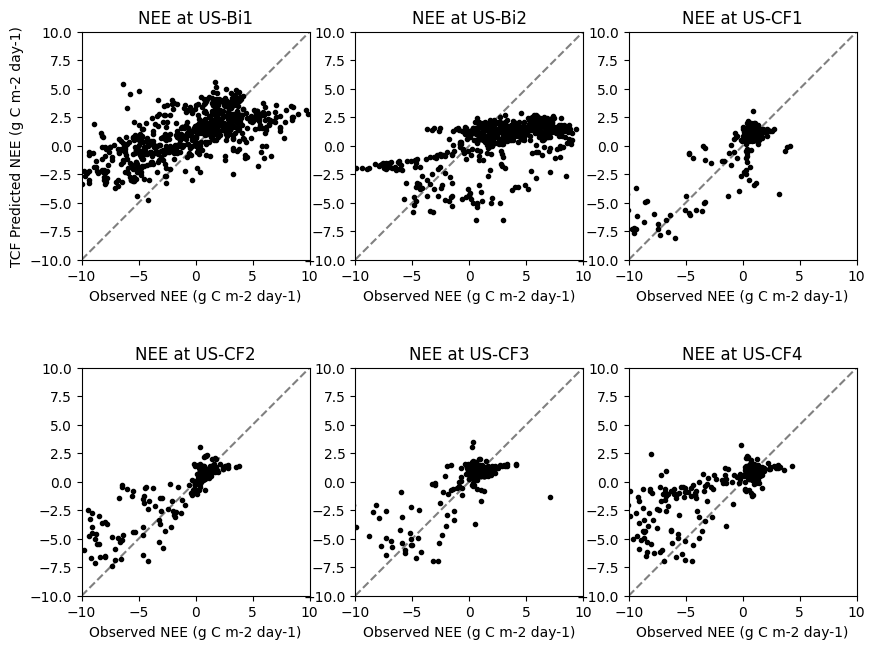

In [16]:
fig, _axs = pyplot.subplots(2, 3, figsize = (10, 8))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot([0, 1], [0, 1], transform = axs[i].transAxes, linestyle = 'dashed', color = 'gray')
    axs[i].plot(nee_obs[t0:t1,i], nee[i], 'k.')
    axs[i].set_title(f'NEE at {datasets[i][0]}')
    axs[i].set_aspect(1)
    axs[i].set_xlim(-10, 10)
    axs[i].set_ylim(-10, 10)
    axs[i].set_xlabel('Observed NEE (g C m-2 day-1)')

axs[0].set_ylabel('TCF Predicted NEE (g C m-2 day-1)')
pyplot.show()

---

## Detailed Comparison

In [17]:
ec_tmin  = np.nan * np.ones((len(all_models), len(dates_list)))
ec_vpd   = ec_tmin.copy()
ec_smrz  = ec_tmin.copy()
ec_smsf  = ec_tmin.copy()
ec_tsoil = ec_tmin.copy()
fpar     = ec_tmin.copy()

for m, model in enumerate(all_models):
    # Load driver (meteorology)
    drivers = drivers_for_tcf(datasets[m][1])
    ft, f_tmin, f_vpd, f_smrz = model.diagnose_emult(drivers[0:6])
    f_tsoil, f_smsf = model.diagnose_kmult(drivers)
    fpar[m] = drivers[0]
    ec_tmin[m] = f_tmin
    ec_vpd[m]  = f_vpd
    ec_smrz[m] = f_smrz
    ec_tsoil[m]  = f_tsoil
    ec_smsf[m] = f_smsf

### GPP Time Series

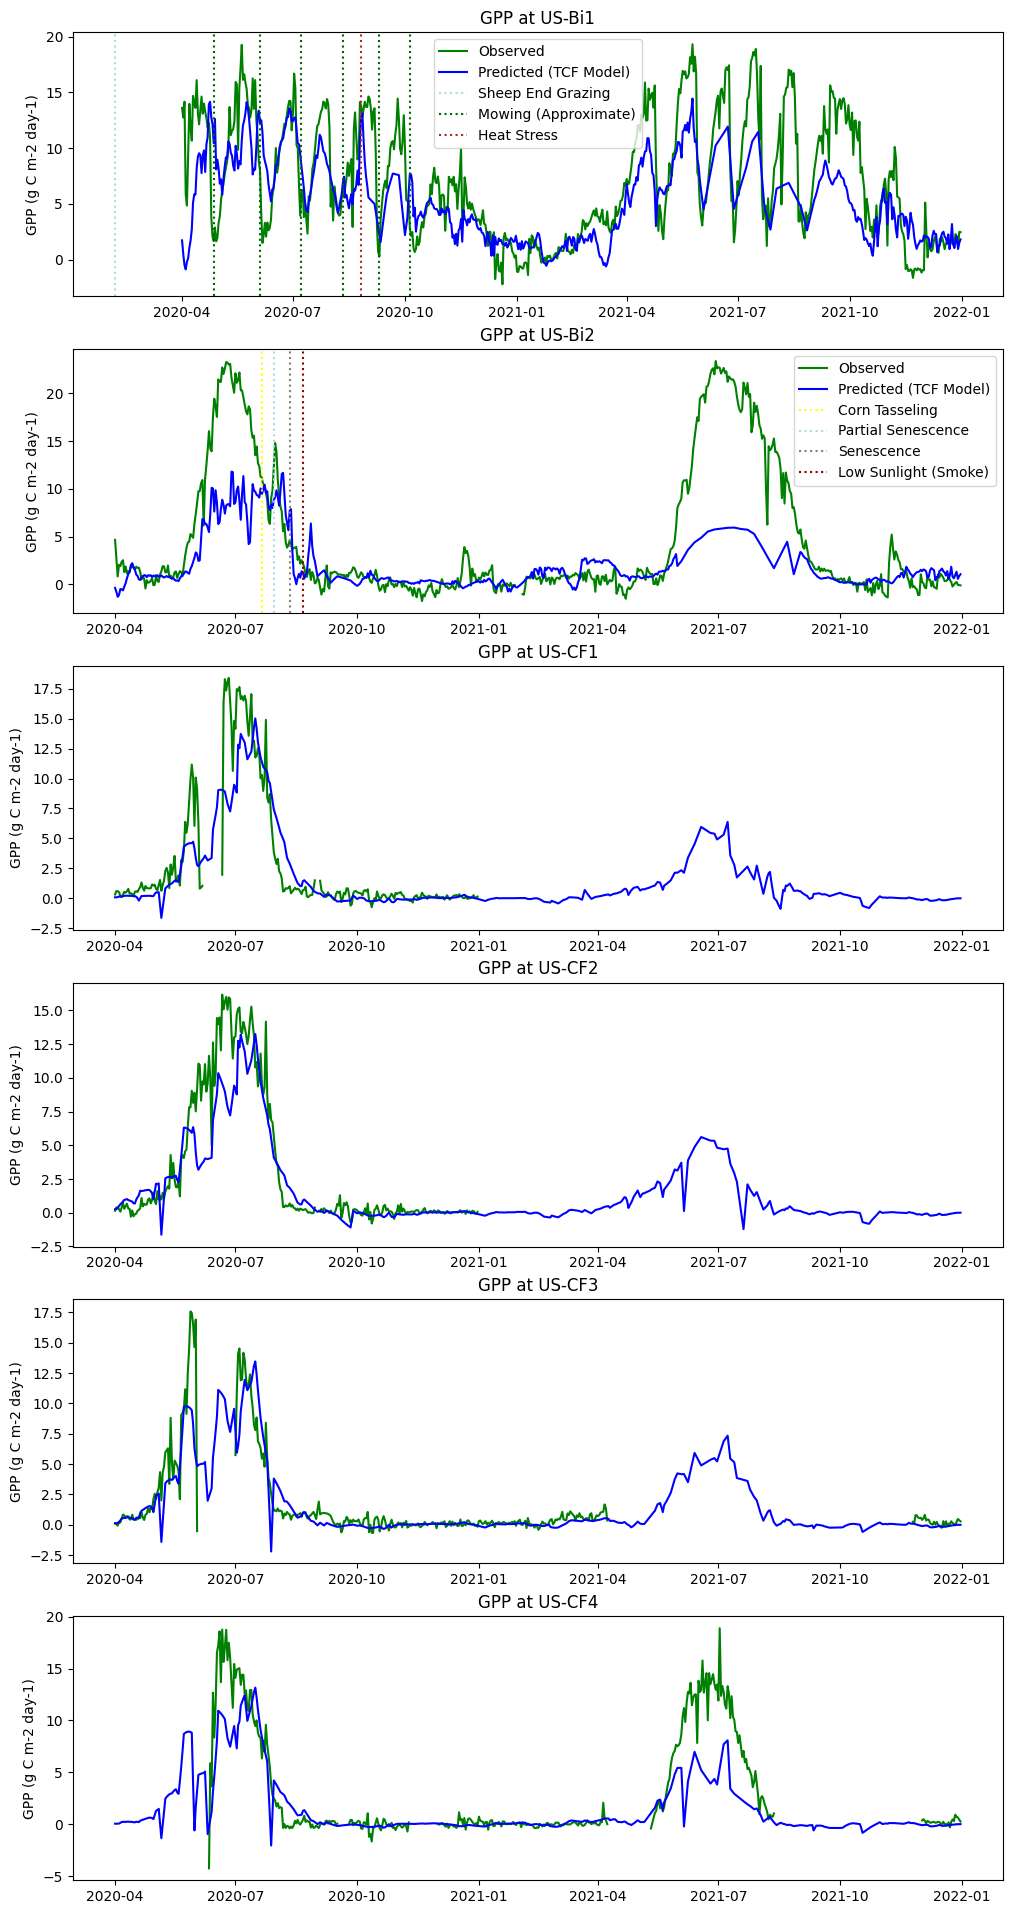

In [18]:
fig, _axs = pyplot.subplots(6, 1, figsize = (12, 24))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot(dates_list, gpp_obs[t0:t1,i], 'g-', label = 'Observed')
    axs[i].plot(dates_list, gpp[i], 'b-', label = 'Predicted (TCF Model)')
    axs[i].set_ylabel('GPP (g C m-2 day-1)')
    axs[i].set_title(f'GPP at {datasets[i][0]}')

axs[0].axvline(datetime.date(2020, 2, 6), label = 'Sheep End Grazing', color = 'lightblue', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 4, 27), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 6, 4), label = 'Mowing (Approximate)', color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 7, 8), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 8, 11), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 9, 10), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 10, 5), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 8, 26), label = 'Heat Stress', color = 'brown', linestyle = 'dotted')
axs[0].legend()
    
axs[1].axvline(datetime.date(2020, 7, 21), label = 'Corn Tasseling', color = 'yellow', linestyle = 'dotted')
axs[1].axvline(datetime.date(2020, 7, 30), label = 'Partial Senescence', color = 'lightblue', linestyle = 'dotted')
axs[1].axvline(datetime.date(2020, 8, 11), label = 'Senescence', color = 'gray', linestyle = 'dotted')
axs[1].axvline(datetime.date(2020, 8, 21), label = 'Low Sunlight (Smoke)', color = 'darkred', linestyle = 'dotted')    
axs[1].legend()

pyplot.show()

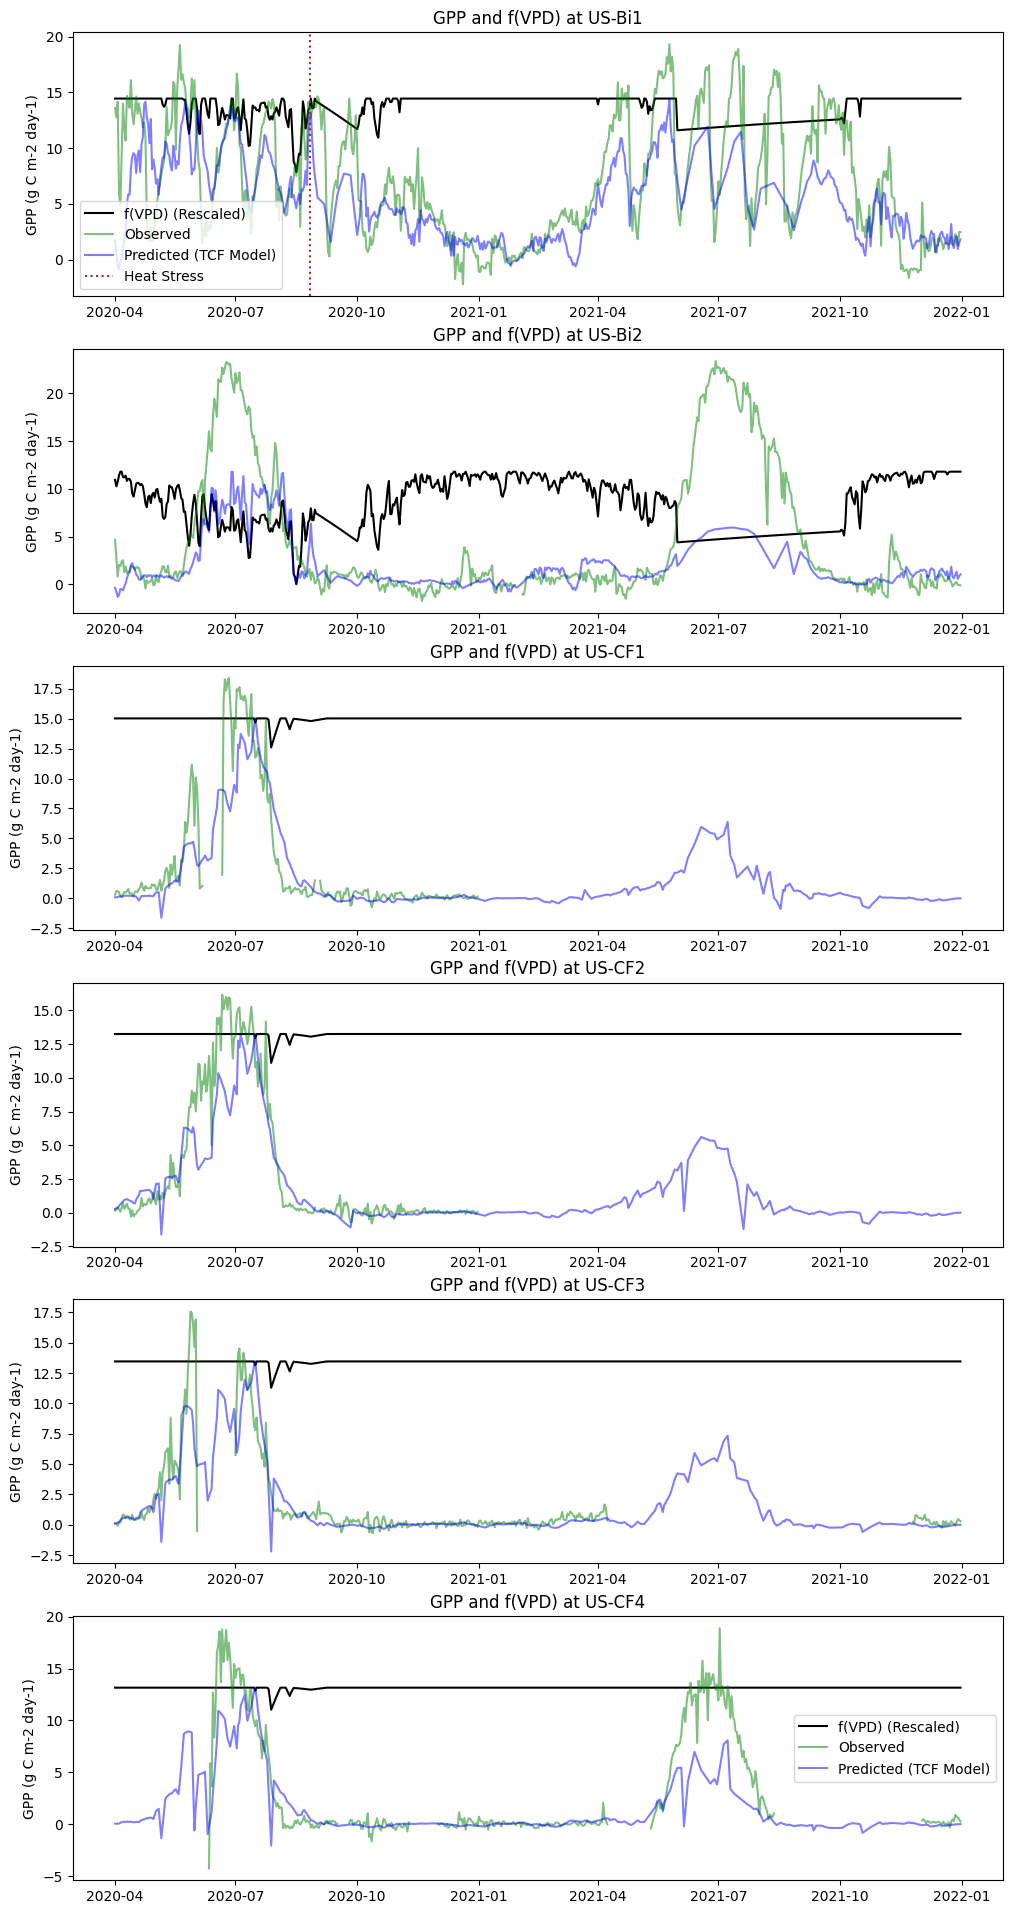

In [19]:
fig, _axs = pyplot.subplots(6, 1, figsize = (12, 24))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot(dates_list, (ec_vpd * gpp.max(axis = 1)[:,np.newaxis])[i], 'k-', label = 'f(VPD) (Rescaled)')
    axs[i].plot(dates_list, gpp_obs[t0:t1,i], 'g-', alpha = 0.5, label = 'Observed')
    axs[i].plot(dates_list, gpp[i], 'b-', alpha = 0.5, label = 'Predicted (TCF Model)')
    axs[i].set_ylabel('GPP (g C m-2 day-1)')
    axs[i].set_title(f'GPP and f(VPD) at {datasets[i][0]}')
    
axs[0].axvline(datetime.date(2020, 8, 26), label = 'Heat Stress', color = 'brown', linestyle = 'dotted')
axs[0].legend()

pyplot.legend()
pyplot.show()

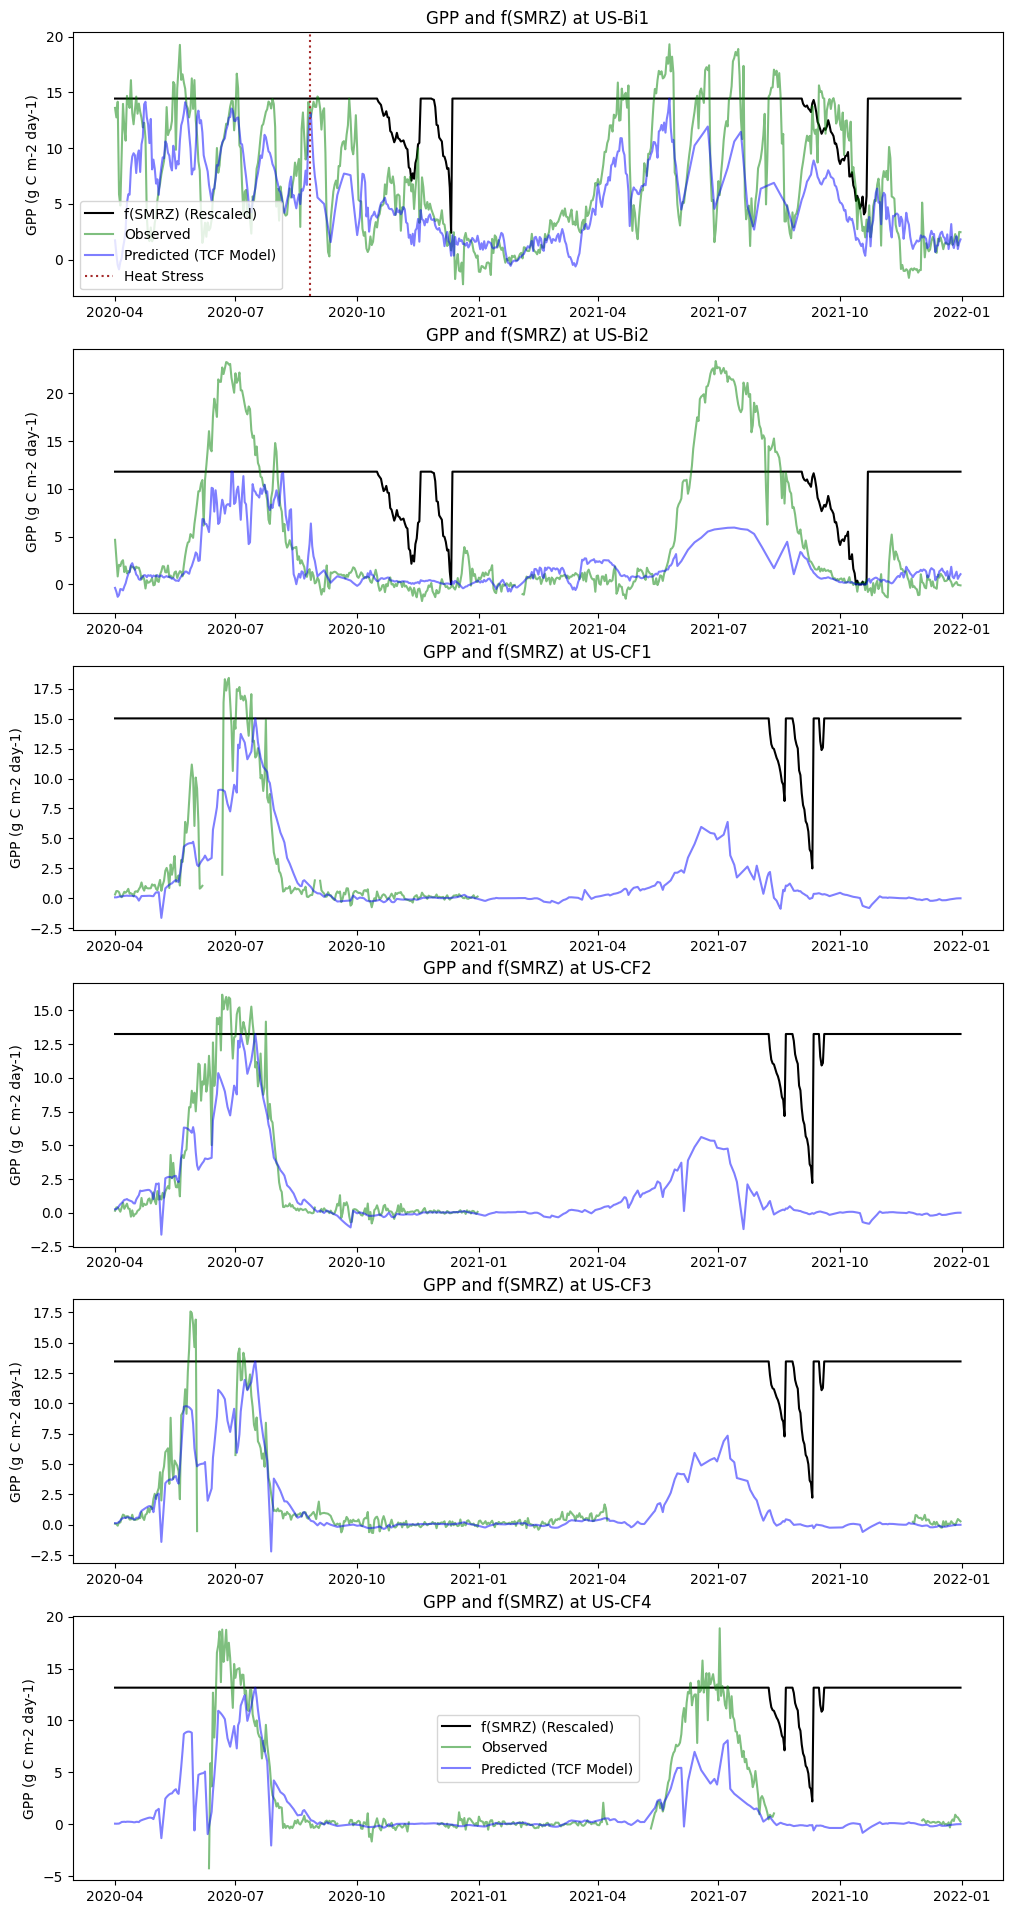

In [20]:
fig, _axs = pyplot.subplots(6, 1, figsize = (12, 24))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot(dates_list, (ec_smrz * gpp.max(axis = 1)[:,np.newaxis])[i], 'k-', label = 'f(SMRZ) (Rescaled)')
    axs[i].plot(dates_list, gpp_obs[t0:t1,i], 'g-', alpha = 0.5, label = 'Observed')
    axs[i].plot(dates_list, gpp[i], 'b-', alpha = 0.5, label = 'Predicted (TCF Model)')
    axs[i].set_ylabel('GPP (g C m-2 day-1)')
    axs[i].set_title(f'GPP and f(SMRZ) at {datasets[i][0]}')
    
axs[0].axvline(datetime.date(2020, 8, 26), label = 'Heat Stress', color = 'brown', linestyle = 'dotted')
axs[0].legend()

pyplot.legend()
pyplot.show()

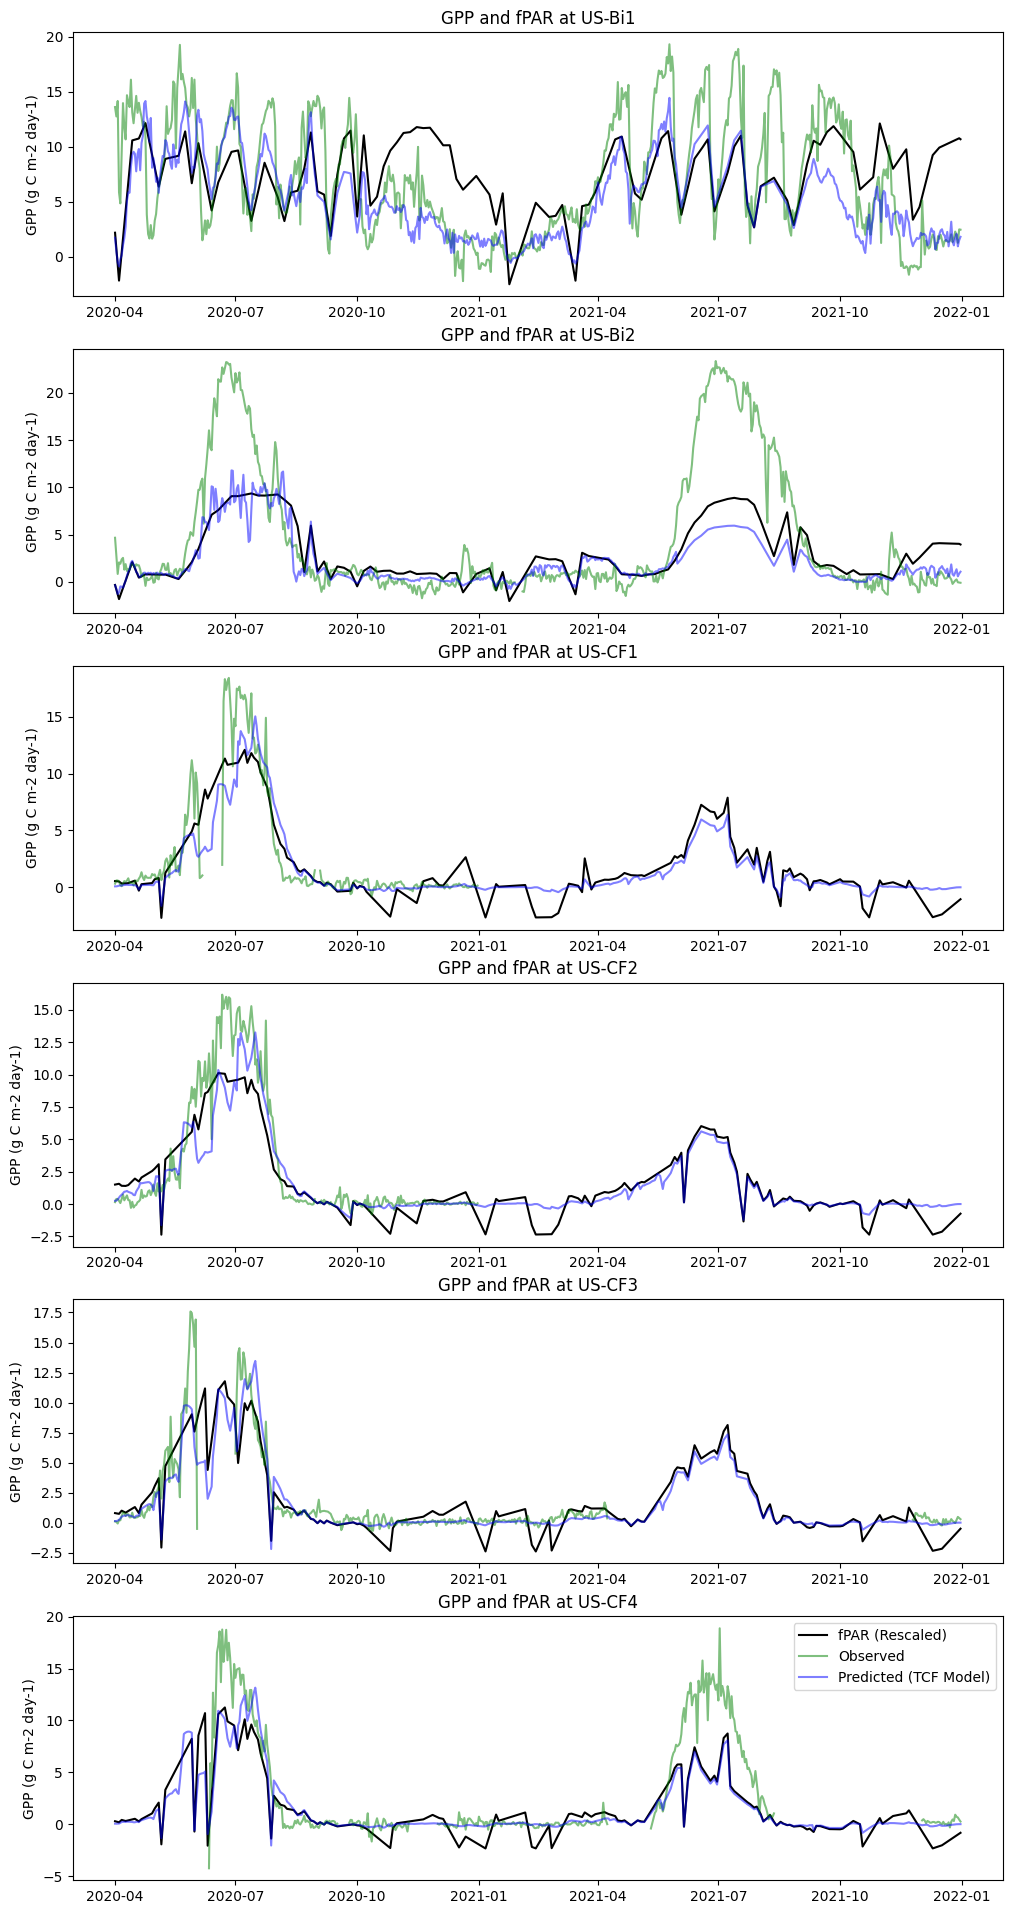

In [21]:
fig, _axs = pyplot.subplots(6, 1, figsize = (12, 24))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot(dates_list, (fpar * gpp.max(axis = 1)[:,np.newaxis])[i], 'k-', label = 'fPAR (Rescaled)')
    axs[i].plot(dates_list, gpp_obs[t0:t1,i], 'g-', alpha = 0.5, label = 'Observed')
    axs[i].plot(dates_list, gpp[i], 'b-', alpha = 0.5, label = 'Predicted (TCF Model)')
    axs[i].set_ylabel('GPP (g C m-2 day-1)')
    axs[i].set_title(f'GPP and fPAR at {datasets[i][0]}')

pyplot.legend()
pyplot.show()

### NEE Time Series

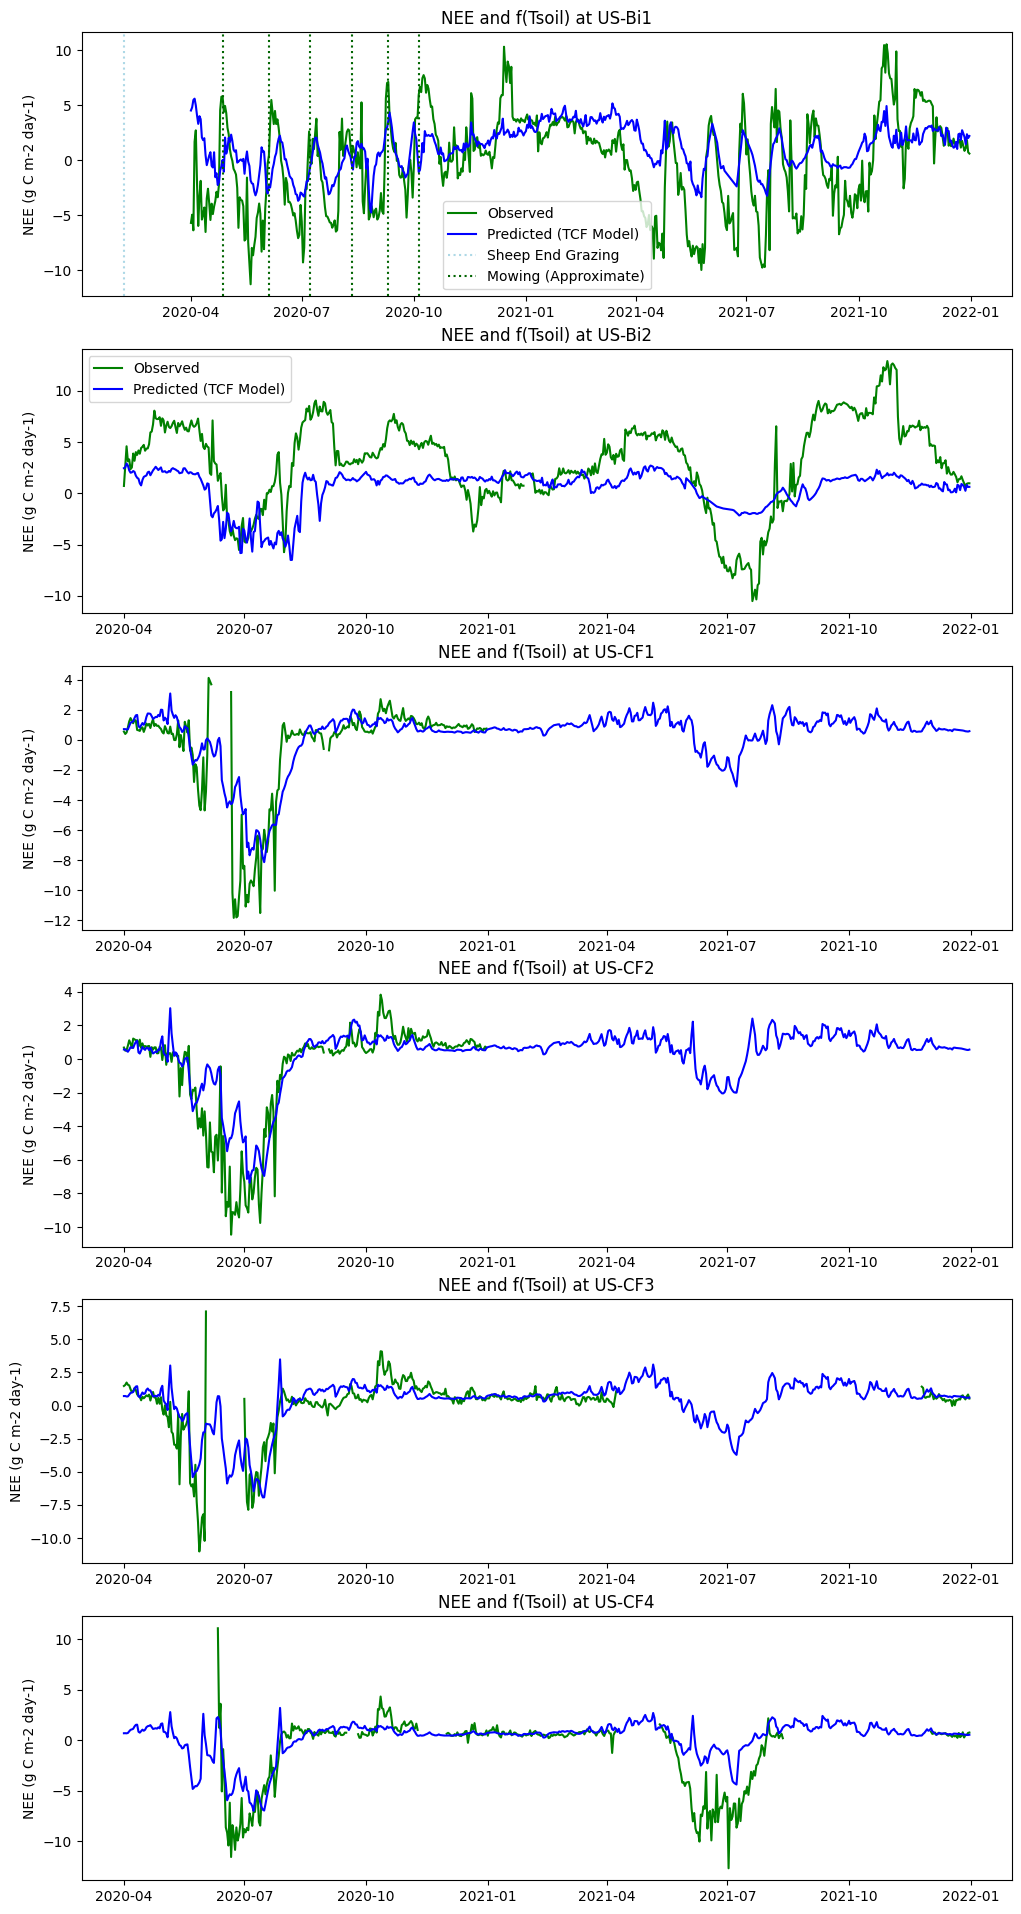

In [22]:
fig, _axs = pyplot.subplots(6, 1, figsize = (12, 24))
axs = _axs.ravel()
for i in range(0, len(all_models)):
    axs[i].plot(dates_list, nee_obs[t0:t1,i], 'g-', label = 'Observed')
    axs[i].plot(dates_list, nee[i], 'b-', label = 'Predicted (TCF Model)')
    axs[i].set_ylabel('NEE (g C m-2 day-1)')
    axs[i].set_title(f'NEE and f(Tsoil) at {datasets[i][0]}')
    
axs[0].axvline(datetime.date(2020, 2, 6), label = 'Sheep End Grazing', color = 'lightblue', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 4, 27), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 6, 4), label = 'Mowing (Approximate)', color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 7, 8), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 8, 11), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 9, 10), color = 'darkgreen', linestyle = 'dotted')
axs[0].axvline(datetime.date(2020, 10, 5), color = 'darkgreen', linestyle = 'dotted')
axs[0].legend()

axs[1].legend()
    
pyplot.show()

---

## Comparison Against Stoichiometric Model

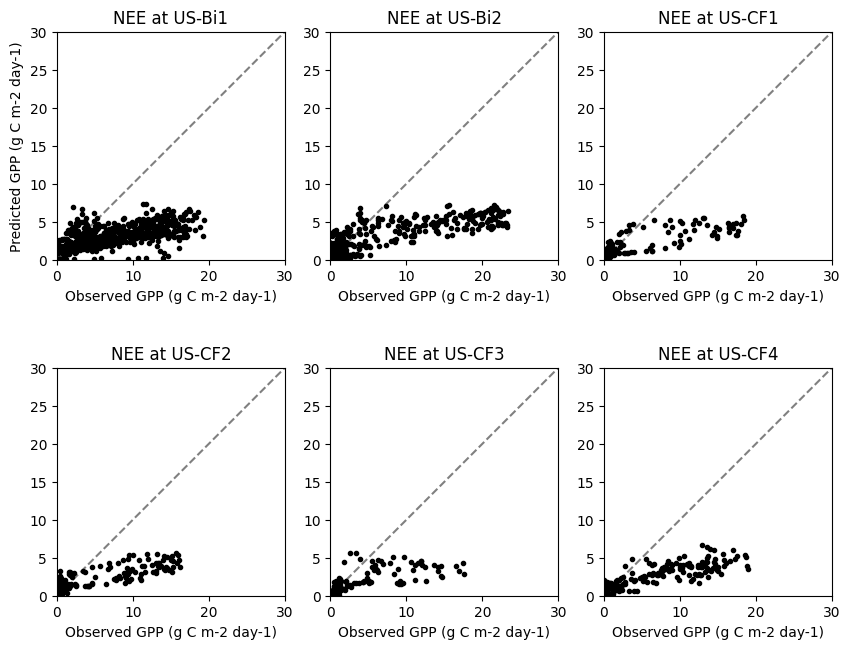

In [23]:
fig, _axs = pyplot.subplots(2, 3, figsize = (10, 8))
axs = _axs.ravel()
for i, site_id in enumerate(SITE_IDS.keys()):
    axs[i].plot([0, 1], [0, 1], transform = axs[i].transAxes, linestyle = 'dashed', color = 'gray')
    axs[i].plot(gpp_obs[t0:t1,i], alt_gpp[i], 'k.')
    axs[i].set_title(f'NEE at {site_id}')
    axs[i].set_aspect(1)
    axs[i].set_xlim(0, 30)
    axs[i].set_ylim(0, 30)
    axs[i].set_xlabel('Observed GPP (g C m-2 day-1)')

axs[0].set_ylabel('Predicted GPP (g C m-2 day-1)')
pyplot.show()

### Validation Statistics

#### RMSE and Normalized RMSE

In [24]:
for i in range(0, len(all_models)):
    mask = np.isnan(gpp_obs[t0:t1,i]) # Mask out NaNs in the observed data
    rmse = mean_squared_error(gpp_obs[t0:t1,i][~mask], alt_gpp[i][~mask], squared = False)
    print(f'{datasets[i][0]}: %.2f [g C m-2 day-1]' % rmse)

US-Bi1: 6.13 [g C m-2 day-1]
US-Bi2: 6.01 [g C m-2 day-1]
US-CF1: 4.14 [g C m-2 day-1]
US-CF2: 4.07 [g C m-2 day-1]
US-CF3: 2.65 [g C m-2 day-1]
US-CF4: 4.32 [g C m-2 day-1]


In [25]:
for i in range(0, len(all_models)):
    mask = np.isnan(gpp_obs[t0:t1,i]) # Mask out NaNs in the observed data
    rmse = mean_squared_error(gpp_obs[t0:t1,i][~mask], alt_gpp[i][~mask], squared = False)
    nrmse = rmse / (np.nanmax(gpp_obs[t0:t1,i]) - np.nanmin(gpp_obs[t0:t1,i]))
    print(f'{datasets[i][0]}: %.1f%%' % (100 * nrmse))

US-Bi1: 28.5%
US-Bi2: 23.9%
US-CF1: 21.6%
US-CF2: 24.0%
US-CF3: 14.5%
US-CF4: 18.7%


#### Pearson's Correlation

In [26]:
for i in range(0, len(all_models)):
    mask = np.isnan(gpp_obs[t0:t1,i]) # Mask out NaNs in the observed data
    corr = np.corrcoef(gpp_obs[t0:t1,i][~mask], alt_gpp[i][~mask])[0,1]
    print(f'{datasets[i][0]}: %.2f' % corr)

US-Bi1: 0.64
US-Bi2: 0.84
US-CF1: 0.84
US-CF2: 0.88
US-CF3: 0.78
US-CF4: 0.89
